# ModSim Project 2: Optimal Configuration of a Second Order High Pass Filter
## Shreya Chowdhary and Kyle McCracken

### What is the configuration of resistors and capacitors in a second order high pass filter that would result in a bode plot that aligns perfectly (or as close as possible) to the theoretical model for a high pass filter?

The bode plots for second order high pass filters don't exactly match the theoretical model for a second-order high pass filter (while first-order high pass filters do match the theoretical model). This is due to a exchange of current between the two high-pass filters. Thus, we decided to create a model that would determine the optimal combination of resistors and capacitors for a given tau to minimize current flow between the two high pass filters in order to minimize the error between the theoretical bode plot and the simulated bode plot.

### Methodology 

We consider the following circuit: 
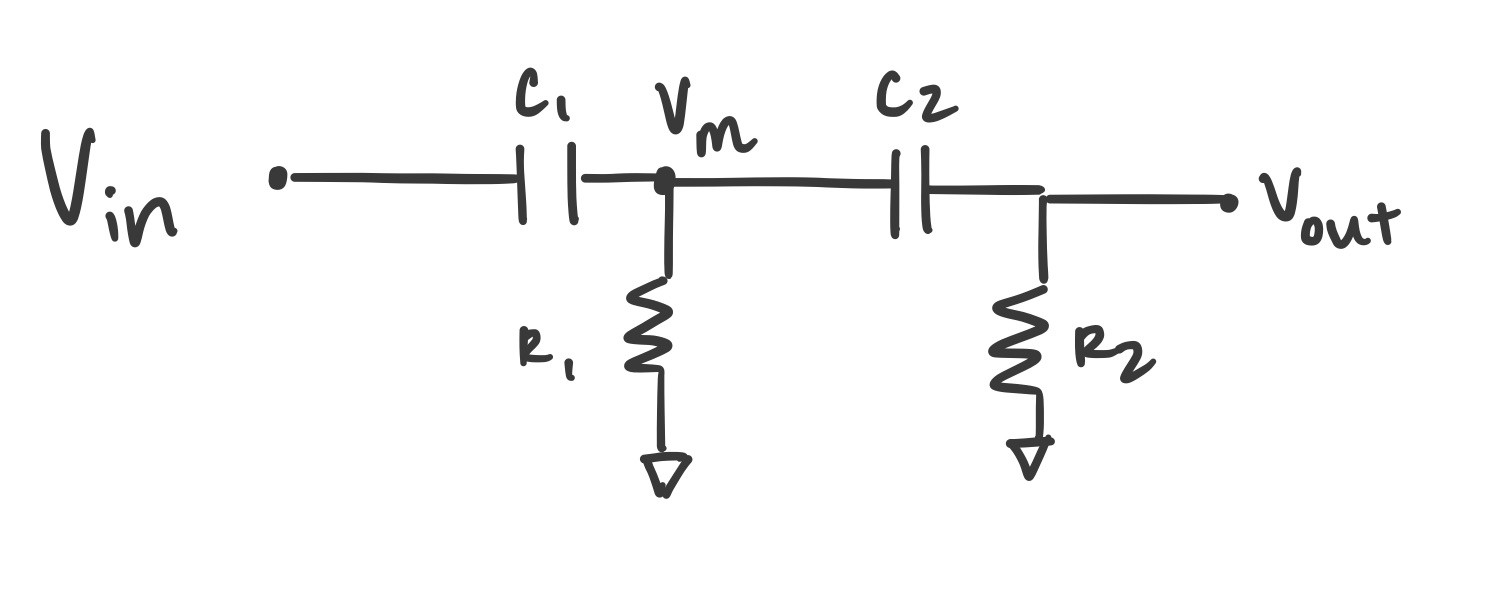

In this circuit, we use $V_{in}$ where $V_{in} = A\sin{2\pi{ft}}$ to represent the sinusoidal input waveform, $V_m$ to represent the voltage at the branch between the two high-pass filters, and $V_{out}$ to represent the output voltage. We use our voltages as the stocks for our stock and flow diagram (shown below).

<img src="modsim_stock.jpg" width=300 title="stock">

Through circuit analysis, we derived differential equations for the flows:

$$\frac{dV_{in}}{dt} = 2\pi{Af\cos{2\pi{ft}}}$$
$$\frac{dV_m}{dt} = \frac{dV_{in}}{dt} - \frac{\frac{V_m}{R_1} + \frac{V_{out}}{R_2}}{C_1}$$
$$\frac{dV_{out}}{dt} = \frac{dV_{out}}{dt} - \frac{V_{out}}{R_2C_2}$$

We made some assumptions....? (Need to explain modelling decisions more).

making system
made system
[1.0e+04 1.0e+04 1.5e-11 1.5e-11]
start error
start bode
done bode
done error
making system
made system
[1.0e+04 1.0e+04 1.5e-11 1.5e-11]
start error
start bode
done bode
done error
making system
made system
[1.0e+04 1.0e+04 1.5e-11 1.5e-11]
start error
start bode
done bode
done error
making system
made system
[1.00000001e+04 1.00000000e+04 1.50000000e-11 1.50000000e-11]
start error
start bode
done bode
done error
making system
made system
[1.00000000e+04 1.00000001e+04 1.50000000e-11 1.50000000e-11]
start error
start bode
done bode
done error
making system
made system
[1.00000000e+04 1.00000000e+04 1.50000002e-11 1.50000000e-11]
start error
start bode
done bode
done error
making system
made system
[1.00000000e+04 1.00000000e+04 1.50000000e-11 1.50000002e-11]
start error
start bode
done bode
done error
making system
made system
[ 1.88327259e+06 -1.46582107e+05  2.68595521e-10 -2.81496623e-09]
start error
start bode
done bode
done error
R1    1.000000e+04
R2   

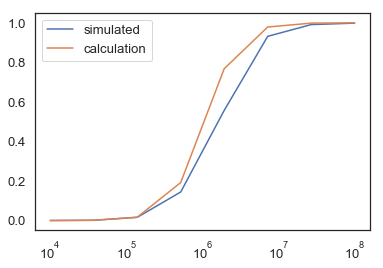

In [7]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

from modsim import *

# Creating the initial state
init = State(Vm=0,
             Vout=0)

# Initializing the configuration of the high pass filter
params = Params(R1=10000,
                R2=10000,
                C1=1.5e-11,
                C2=1.5E-11)


# Initializing the system configurations 
# freqs is the number of frequencies to sweep through 
# numwavels is the number of wavelengths simulated per frequency 
# stepres is ...?
setsystem = System(tau = 1.5e-7,
                   A=0.5, #Amplitude of Vin wave
                   init=init,
                   t0=0,
                   freqs = 8,
                   stepres = 200,
                   numwavels = 4)

def make_system(params, setsystem):
    '''
    Creates a system object.
    '''
    # param params: the configuration for the circuit (R1, R2)
        
    # Creates a system object representing the circuit with the correct configuration.
    print('making system')
    R1, R2, C1, C2 = params
    
    # Sets the configuration of the filter 
    setsystem.set(params = params)
    
    # Determines the characteristic cut off frequency 
    fc = 1/(2*np.pi*setsystem.tau)
    
    # Determines the maximum and minimum for the range of frequencies to sweep when creating the bode plot
    # These frequencies wil be 2 orders of magnitude above and below the cut-off frequency, so we select
    # out the steep sloped part of the bode plot
    flow = int(np.log10(fc))-2
    fhigh = int(np.log10(fc))+2
    
    setsystem.set(f1 = flow, f2 = fhigh)
    print('made system')
    system = setsystem

    return system

def slope_func(init, t, system):
    '''
    Determines the ODEs for Vin, Vm, and Vout, which will be used later for the ODE solver.
    '''
    # param init: the initial state of the system
    # param t: the time at which this function will be evaluated
    # param system: the system object

    unpack(system)
    R1, R2, C1, C2= system.params

    vm, vout = init

    # ODEs for Vin, Vm, Vout
    # We treat dVin as a variable because Vin is not influenced by Vm or Vout, but influences both
    dvin = 2 * np.pi * A * f * np.cos(2*np.pi*f*t)
    dvm = dvin - (vm/R1 + vout/R2) / C1
    dvout = dvm - vout / (R2*C2)

    return dvm, dvout

def run_bode(system):
    '''
    Generates a bode plot for the given set of frequencies.
    '''
    # param system: the system object
        
    unpack(system)
    print('start bode')
    
    # Creates a set of frequencies on a log scale
    farray = np.logspace(f1, f2, freqs)

    Re = TimeSeries()

    for f in farray:
        system.set(f=f, t_end = numwavels / f)

        # Determines the maximum step length, to force the bode plot to run faster
        max_step = (system.t_end - t0) / (stepres)
        results, details = run_ode_solver(system, slope_func, max_step = max_step)

        # Uses nfev for the # of steps and to select out the tail
        tail = int(details.nfev/(2*np.pi*numwavels))
        amplitudeM = results.Vout.tail(tail).ptp()
        Re[f] = amplitudeM
        
    print('done bode')
    return Re

def run_freq(system):
    '''
    Runs the simulation for a specific frequency (in this case, the cut off frequency).
    '''
    
    print('start freq')
    
    # Calculates the cut off frequency 
    fc = 1/(2*np.pi * system.tau)
    print(fc)
    
    # Sets the frequency to run the bode plot at to the cut off
    system.set(f = fc)
    
    system.set(t_end = system.numwavels / system.f)
    unpack(system)


    max_step = (t_end - t0) / (stepres)

    results, details = run_ode_solver(system, slope_func, max_step = max_step)
    tail = int(details.nfev/(2*np.pi*numwavels))
    amplitudeM = results.Vout.tail(tail).ptp()

    print('done freq')
    return amplitudeM


def run_calc(system):
    '''
    Determines what the theoretical model should look like for the given frequencies
    '''
    unpack(system)
    R1, R2, C1, C2 = system.params

    farray = np.logspace(f1, f2, freqs)
    C = TimeSeries()

    for f in farray:
        
        # Uses circuit theory to calculate the amplitude
        w = 2*np.pi*f
        rcw1 = R1*C1*w
        rcw2 = R2*C2*w
        amplitudeC = (rcw1*rcw2) / (np.sqrt(1 + rcw1**2) * np.sqrt(1 + rcw2**2))
        C[f] = amplitudeC

    return C

def error_func(params, setsystem):
    '''
    Determines the error between the simulated bode plot and the theoretical bode plot.
    '''
    system = make_system(params, setsystem)
    print(params)
    print('start error')
    #ampM = run_freq(system)
    #ampC = system.A

    results = run_bode(setsystem)
    calcs = run_calc(setsystem)

    errors = results - calcs
    print('done error')
    return errors

def plot_bode_plot():
    '''
    Plots the simulated bode plot against the theoretical model
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xscale('log')
    lns1 = ax.plot(results, label = 'simulated')
    lns2 = ax.plot(run_calc(system), label = 'calculation')
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc = 'best')
    savefig('graphs\BodePlotLowRes2.png')

best_params, fit_details = fit_leastsq(error_func, params, setsystem, maxfev = 5)
print(best_params, setsystem.tau/best_params.R1, setsystem.tau/best_params.R2)

system = make_system(best_params, setsystem)
results = run_bode(system)
plot_bode_plot()

### Results 

According to our model, the optimal configuration for resistors and capacitors in a second order high pass filter with a tau of 1.5e-7 would be an $R_1$ and $R_2$ of 1e4 and a $C_1$ and $C_2$ of 1.5e-11.

### Interpretation

Significant failings of the model...? 

One issue we encountered was with the model choosing Rs and Cs that were negative. (How did we resolve this issue again?)

The model ends up basically eliminating the second filter entirely, so in future iterations, we would put more constraints on the Rs and Cs it could choose to prevent it from choosing Rs and Cs for the second filter that are effectively close to 0. 

In future iterations of the model, we might try to increase the realism of the model. For example, there is a standard set of capacitor values used in electrical engineering, so we might try to force the model to choose exclusively these capacitors and vary the resistor values more freely (rather than the other way around).

### Abstract